# Monte Carlo Methods: Numerical computations through random sampling

## Why Monte Carlo?

### Because some problems are too complicated or too uncertain to solve exactly

Draw random samples that follow a predefined probability distribution to:

* find (multiple) maxima of the probability distribution
* calculate integrals (i.e., expectation values) of functions, weighted by the probability distribution
* characterize the probability distribution, find correlations between parameters, etc.

In [14]:
import numpy as np

import matplotlib 
% matplotlib inline
% config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
matplotlib.rcParams['xtick.labelsize'] = 14.0
matplotlib.rcParams['ytick.labelsize'] = 14.0
import matplotlib.pyplot as plt

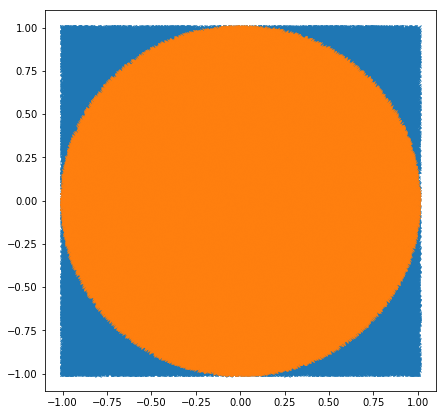

2D: 3.14728
3D: 3.1386
4D: 3.13774441279
5D: 3.1451867989


In [13]:
N=100000 # the more random samples we have, the more accurate our result is
x = np.random.uniform(-1.,1.,N)
y = np.random.uniform(-1.,1.,N)
r=np.sqrt(x*x+y*y)
plt.figure(figsize=(7,7))
plt.plot(x,y,'x')
plt.plot(x[r<1],y[r<1],'x')
plt.show()
print '2D:',4.*len(x[r<1])/len(x)

z = np.random.uniform(-1.,1.,N)
r=np.sqrt(x*x+y*y+z*z)
print '3D:',6.*len(x[r<1])/len(x)

t = np.random.uniform(-1.,1.,N)
r=np.sqrt(x*x+y*y+z*z+t*t)
print '4D:',np.sqrt(32.*len(x[r<1])/len(x))

f = np.random.uniform(-1.,1.,N)
r=np.sqrt(x*x+y*y+z*z+t*t+f*f)
print '5D:',np.sqrt(60.*len(x[r<1])/len(x))

## Drawing samples from a one-dimensional PDF

### Drawing uniformly distributed (pseudo-)random numbers

Computers are deterministic. However, we can generate so-called pseudo-random numbers (or even trully random ones, but that's difficult and slow).

Idea: Use some formula whose outcome depends sensitively on the input; iterate.

Note: Need starting point for the iteration (random number seed), but that makes the result reproducible (good for testing and debugging).

In [16]:
def rng(m=2**32, a=1103515245, b=12345):
    """This function updates the (pseudo-)random number to a new one."""
    rng.current = (a*rng.current + b) % m
    return 1.*rng.current/m

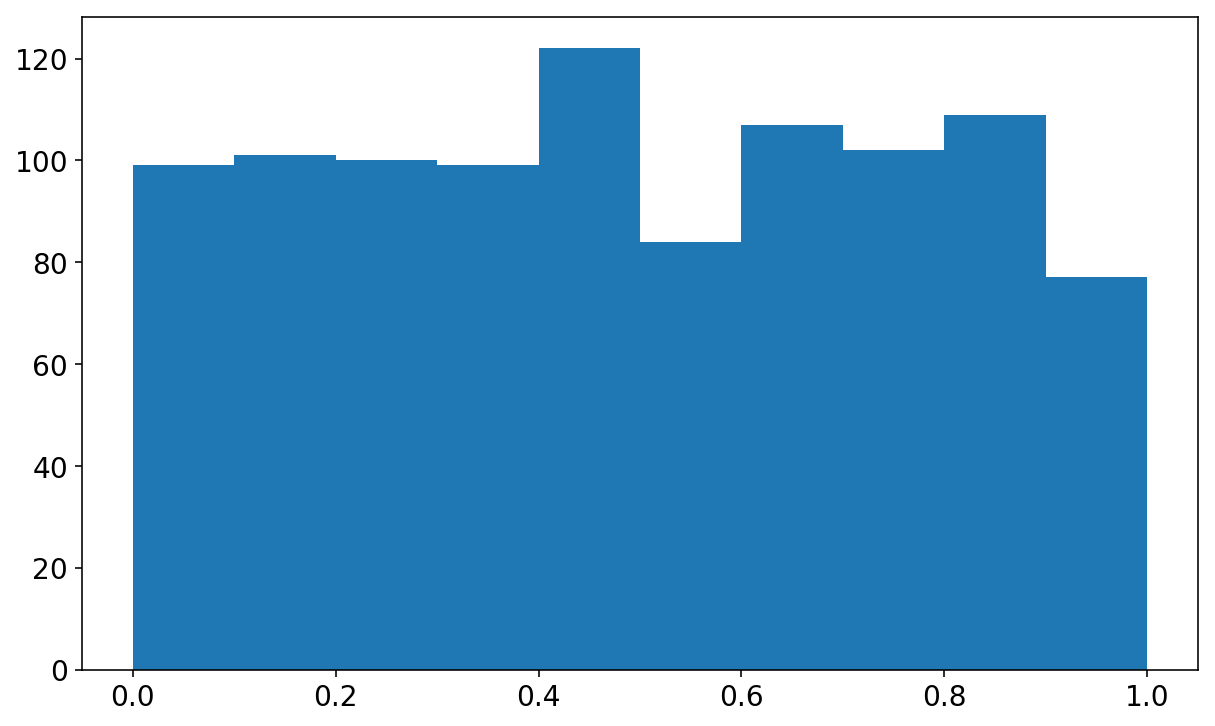

In [22]:
rng.current = 101 #setting the random number seed
random_numbers = np.array([rng() for i in range(1000)]) #Draw a few random numbers
plt.hist(random_numbers,range=(0.,1.),bins=10) #plot them
plt.show()

In numpy, this is already implemented as np.random.random() (or np.random.uniform())

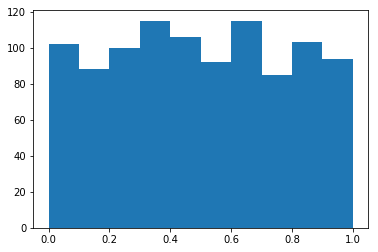

In [5]:
np.random.seed(101)
random_numbers2 = np.random.random(1000)
plt.hist(random_numbers2,range=(0.,1.),bins=10)
plt.show()

In [6]:
np.random.seed(None)
print np.random.random(1)
np.random.seed(10)
print np.random.random(1)

[ 0.8663418]
[ 0.77132064]


### Drawing non-uniformly distributed random values

We can draw random numbers uniformly between 0 and 1 and then transform them to follow any one-dimensional distribution. In this example, we will use a simple Gaussian distribution.

* Calculate cumulative probability distribution (CDF): $\mathrm{CDF}(x) = \int_{-\infty}^x \mathrm{d}x' P(x)$
* invert that function to get the inverse cumulative probability distribution (iCDF)
* draw random values $y$ between 0 and 1
* evaluate $\mathrm{iCDF}(y)$ to find values of $x$ following the distribution $P(x)$

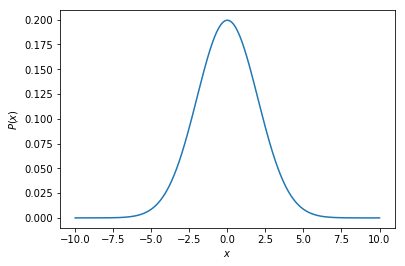

In [7]:
xmin = -10. #set up an array of x-values
xmax = 10.
dx = 0.01
x = np.arange(xmin,xmax + dx,dx)

sigma = 2. #set the standard deviation of the Gaussian
P = 1./(2.*np.pi*sigma**2)**0.5*np.exp(-x**2/(2.*sigma**2)) #Gaussian PDF

plt.plot(x,P)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(x)$')
plt.show()

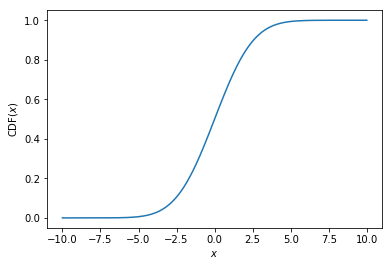

In [8]:
from scipy.special import erf
CDF = 0.5*(1. + np.sign(x)*erf(np.abs(x/2**0.5/sigma))) #Gaussian CDF

plt.plot(x,CDF)
plt.xlabel(r'$x$')
plt.ylabel(r'CDF$(x)$')
plt.show()

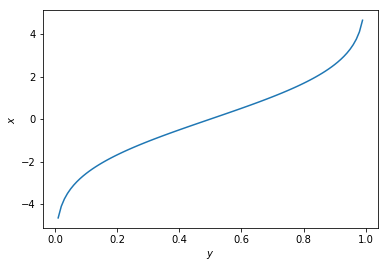

In [9]:
from scipy.special import erfinv
y = np.arange(0.,1.+0.01,0.01)

def iCDF(y,sigma): #inverse CDF
    return 2**0.5*sigma*erfinv(2.*y - 1.)

iCDF_arr = iCDF(y,sigma)
plt.plot(y,iCDF_arr)
plt.xlabel(r'$y$')
plt.ylabel(r'$x$')
plt.show()

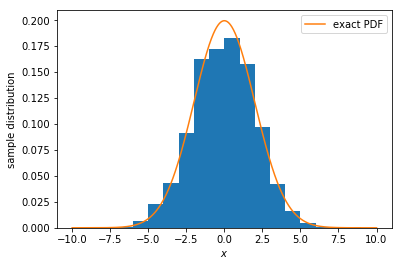

In [10]:
n = 2000 #Number of random samples to draw

yvals = np.random.uniform(0.,1.,n) #Draw uniformly distributed values for y
xvals = iCDF(yvals,sigma) #Convert these values to values of x

plt.hist(xvals,range=(-10,10),bins=20,normed=True) #plot a histogram for x
plt.xlabel(r'$x$')
plt.ylabel(r'sample distribution')
plt.plot(x,P,label='exact PDF')
plt.legend()
plt.show()

With these random samples, we can estimate some expectation values, for example the first few moments of the Gaussian distribution:

In [11]:
print 'zeroth order:', 1., (xvals**0).sum()/n
print 'first order:', 0., (xvals**1).sum()/n
print 'second order:', sigma**2, (xvals**2).sum()/n
print 'third order:', 0., (xvals**3).sum()/n
print 'fourth order:', 3.*sigma**4, (xvals**4).sum()/n

zeroth order: 1.0 1.0
first order: 0.0 -0.0176481756912
second order: 4.0 4.13740857661
third order: 0.0 -0.331005317777
fourth order: 48.0 50.842488964


In numpy, drawing Gaussian random numbers is also provided as a predefined function (np.random.normal()):

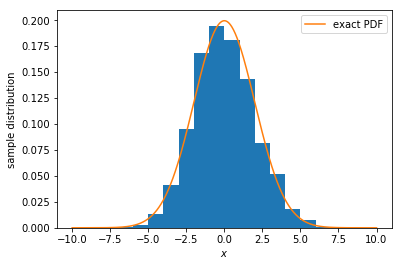

In [12]:
xvals2 = np.random.normal(0.,sigma,n)

plt.hist(xvals2,range=(-10,10),bins=20,normed=True) #plot a histogram for x
plt.xlabel(r'$x$')
plt.ylabel(r'sample distribution')
plt.plot(x,P,label='exact PDF')
plt.legend()
plt.show()

## Drawing from N-dimensional PDFs -- rejection sampling

In more than one dimension, there is no well-defined cumulative distribution function. Thus, we have to come up with a new idea:

* Sample (some region of) N-dimensional space following a simple PDF $Q(x)$ (we will use a uniform distribution).
* Add an acceptance-rejection step that accepts the sample $x$ with probability $P(x)/(c\ Q(x))$.
* Choose $c$ such that $P(x) < c\ Q(x)$ for all $x$ (but ideally not too large).

We will use a two-dimensional Gaussian in this example.

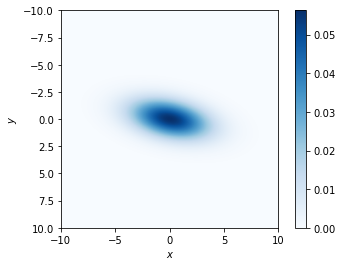

In [13]:
#Set up a two-dimensional grid for plotting purposes:
xvals = np.arange(-10,10.01,0.01)
yvals = np.arange(-10,10.01,0.01)
gridx, gridy = np.meshgrid(xvals,yvals)

#Define the two-dimensional Gaussian:
cov_xx = 6.
cov_yy = 1.5
cov_xy = 1.0
cov = np.array([[cov_xx,cov_xy],[cov_xy,cov_yy]])
invcov = np.linalg.inv(cov)

def twoDGauss(x,y,cov,invcov):
    det = np.linalg.det(cov)
    norm = 1./(2.*np.pi)/det**0.5
    return norm*np.exp(-0.5*(x*(invcov[0,0]*x + invcov[0,1]*y) + y*(invcov[1,0]*x + invcov[1,1]*y)))

#Evaluate the Gaussian at all grid points and plot it:
G = twoDGauss(gridx,gridy,cov,invcov)

plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.show()

In [14]:
#Define drawing step:
def draw_sample():
    return np.random.uniform(-10,10,2) #two-dimensional uniform distribution

#Define the acceptance-rejection step:
c = 40.
D = 2 #dimension of the parameter space

def AcceptReject(c,D,P,*Pargs):
    """This function returns `True' if the sample is accepted and `False' if not. We use a
    variable-length argument list `*Pargs' to be able to use any probability function `P' that we
    might come up with"""
    Pval = P(*Pargs)
    proposalval = 1./20**D #The proposal density is 1/20*1/20
    prob = Pval/(c*proposalval)
    return np.random.choice([True,False],p=[prob,1.-prob])

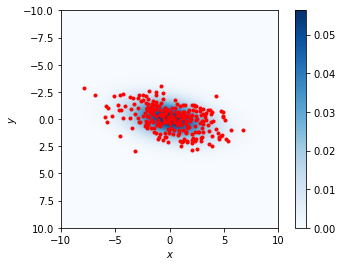

acceptance ratio: 0.0254


In [20]:
#Draw some samples:
N = 10000 #number of samples to draw
count = 0 #count the accepted samples
samples = [] #store the accepted samples

for i in range(N):
    samp = draw_sample()
    acc = AcceptReject(c,D,twoDGauss,samp[0],samp[1],cov,invcov)
    if acc:
        count += 1
        samples.append(samp)
samples = np.array(samples)

plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(samples[:,0],samples[:,1],'.',color='red')
plt.show()
print 'acceptance ratio:', 1.*count/N

In [21]:
#Let's calculate some moments of the PDF:
samples = np.array(samples)
print 'mean x:', np.mean(samples[:,0])
print 'mean y:', np.mean(samples[:,1])
print 'variance in x-direction:', np.mean(samples[:,0]**2)
print 'variance in y-direction:', np.mean(samples[:,1]**2)
print 'covariance of x and y:', np.mean(samples[:,0]*samples[:,1])

mean x: 0.177774413393
mean y: -0.0682176006352
variance in x-direction: 6.75463114513
variance in y-direction: 1.46350263892
covariance of x and y: 1.29298849131


If we didn't know we were drawing from a Gaussian distribution, this would be invaluable information in order to characterize our PDF.

Now let's see what happens if we go to higher dimensions. For simplicity, we use a symmetric Gaussian without correlations.

In [22]:
#Define the D-dimensional Gaussian:
sigma = 2.
def DdimGauss(xvec,sigma,D):
    det = sigma**(2*D)
    norm = 1./(2.*np.pi)**(D/2.)/det**0.5
    return norm*np.exp(-0.5*np.dot(xvec,xvec/sigma**2))

#Define the drawing step:
def draw_sample_Ddim(D):
    return np.random.uniform(-10,10,D) #D-dimensional uniform distribution

In [23]:
#Draw some samples:
N = 10000 #number of samples to draw
count = 0 #count the accepted samples
samples = [] #store the accepted samples
D = 2

#Here we are cheating a bit: Since we know what the maximum of the D-dimensional PDF is, we can
#calculate the optimal value of c to use:
c = DdimGauss(np.zeros(D),sigma,D)*20.**D

for i in range(N):
    samp = draw_sample_Ddim(D)
    acc = AcceptReject(c,D,DdimGauss,samp,sigma,D)
    if acc:
        count += 1
        samples.append(samp)

print 'acceptance ratio:', 1.*count/N

acceptance ratio: 0.0646


This problem is known as "the curse of dimensionality". What do you think we could do to increase the acceptance ratio?

Until now we have been drawing samples randomly in some range without using any 'past experience' of where samples have been accepted.

## Markov Chain Monte Carlo -- Metropolis Hastings

Markov Chain: Draw random samples in an ordered chain:

* "Markov" property: Each sample depends on the sample before, but not on any other samples
* Pro: Curse of dimensionality less severe
* Con: Successive samples are correlated -> need to discard many of them to obtain a set of independent samples

Specific example: Metropolis-Hastings

* Select a "proposal density" $Q(x'|x)$ to draw a new sample $x'$ given a previous sample $x$
* If $P(x') \geq P(x)$, accept the new sample
* If $P(x') < P(x)$, accept the new sample with probability $(P(x')/P(x))(Q(x|x')/Q(x'|x))$
* If a sample is rejected, the chain stays at the same position (i.e., the old sample is repeated).
* Note that the normalization of $P$ doesn't matter.

Let's work again with our two-dimensional Gaussian.

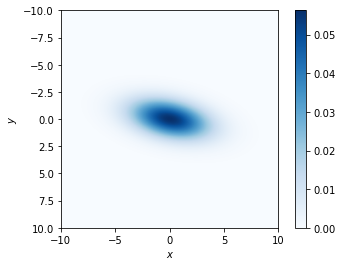

In [24]:
#Set up a two-dimensional grid for plotting purposes:
xvals = np.arange(-10,10.01,0.01)
yvals = np.arange(-10,10.01,0.01)
gridx, gridy = np.meshgrid(xvals,yvals)

#Define the two-dimensional Gaussian:
cov_xx = 6.
cov_yy = 1.5
cov_xy = 1.0
cov = np.array([[cov_xx,cov_xy],[cov_xy,cov_yy]])
invcov = np.linalg.inv(cov)
def twoDGauss(samp,cov,invcov):
    x = samp[0]
    y = samp[1]
    det = np.linalg.det(cov)
    norm = 1./(2.*np.pi)/det**0.5
    return norm*np.exp(-0.5*(x*(invcov[0,0]*x + invcov[0,1]*y) + y*(invcov[1,0]*x + invcov[1,1]*y)))

#Evaluate the Gaussian at all grid points and plot it:
G = twoDGauss([gridx,gridy],cov,invcov)

plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.show()

In [25]:
#Define the proposal step (we are using a symmetric Gaussian proposal density):
def proposal(oldsamp,sigmaprop,D):
    newsamp = oldsamp + np.random.normal(0.,sigmaprop,D)
    return newsamp

#Define the acceptance-rejection step (return the new sample and a boolean that tells us whether
#or not the new sample was accepted):
def accept(newsamp,oldsamp,paramrange,P,*Pargs):
    if not ((np.array([p1 - p2 for p1, p2 in zip(newsamp, np.transpose(paramrange)[:][0])])>0).all() \
            and (np.array([p1 - p2 for p1, p2 in zip(np.transpose(paramrange)[:][1],newsamp)])>0).all()):
        acc = False
        return acc, oldsamp # make sure the samples are in the desired range
    newprob = P(newsamp,*Pargs)
    oldprob = P(oldsamp,*Pargs)
    if newprob >= oldprob:
        acc = True
        return acc, newsamp
    else:
        prob = newprob/oldprob
        acc = np.random.choice([True,False],p=[prob,1.-prob])
        return acc, acc*newsamp + (1. - acc)*oldsamp #Note that this is either newsamp or oldsamp

#Define function that runs an entire chain:
def run_chain(steps,paramrange,sigmaprop,D,P,*Pargs):
    oldsamp=np.array([np.random.uniform(paramrange[d][0],paramrange[d][1]) for d in range(D)])#Draw a random starting point
    count = 0 #Count the number of accepted samples
    samples = [oldsamp] #Store all samples
    for i in range(steps):
        newsamp = proposal(oldsamp,sigmaprop,D) #Propose a new sample
        acc, newsamp = accept(newsamp,oldsamp,paramrange,P,*Pargs) #decide whether or not to accept it
        samples.append(newsamp) #Add the sample to the list of samples
        if acc:
            count += 1
        oldsamp = newsamp #Move to the new sample
    ar = 1.*count/steps #compute the acceptance ratio
    return np.array(samples), ar


acceptance ratio: 0.665


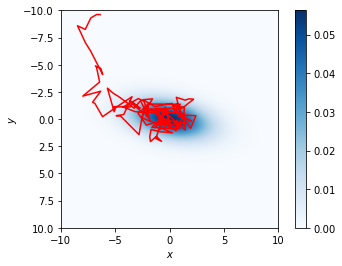

In [66]:
#Run a chain:
np.random.seed(11)
Nsteps = 200 #number of steps to run the chain for
sigmaprop = 1 #width of the proposal distribution
D = 2 #dimension of the parameter space
samples, ar = run_chain(Nsteps,np.transpose(np.array([[-10]*D,[10]*D])),sigmaprop,D,twoDGauss,cov,invcov) #run the chain
print 'acceptance ratio:', ar

#Plot the chain on top of the 2D-density:
plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(samples[:,0],samples[:,1],'-',color='red')
plt.show()

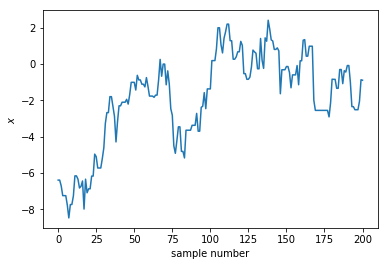

In [67]:
#plot the x-values of the samples:
plt.plot(samples[:,0])
plt.xlabel(r'sample number')
plt.ylabel(r'$x$')
plt.show()

This is called a 'Markov chain'. What do you think a markov chain should look like?

In [68]:
#use the plot to determine how many samples to throw out as "burn-in":
burnin = 50
non_burnin_samples = samples[burnin:]

But the samples are not independent

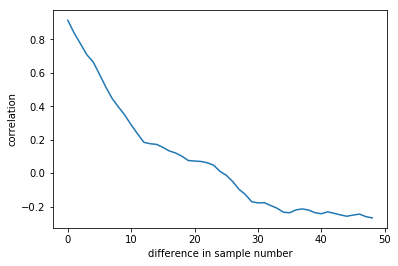

In [69]:
#calculate the auto-correlation of the remaining samples:
xmean=(np.mean(non_burnin_samples[:,0]))
xvar=(np.var(non_burnin_samples[:,0]))
ACL=np.array([(((non_burnin_samples[h:,0]-xmean)*(non_burnin_samples[:-h,0]-xmean)).sum())/(len(non_burnin_samples[:,0])-h)/xvar for h in range(1,50)])                              

plt.plot(ACL)
plt.xlabel(r'difference in sample number')
plt.ylabel(r'correlation')
plt.show()

In [70]:
#use the plot to determine the correlation length between samples
corrlength = 20
independentsamples = non_burnin_samples[::corrlength]
print independentsamples.shape
print 'effective acceptance ratio:', 1.*independentsamples.shape[0]/Nsteps

(8, 2)
effective acceptance ratio: 0.04


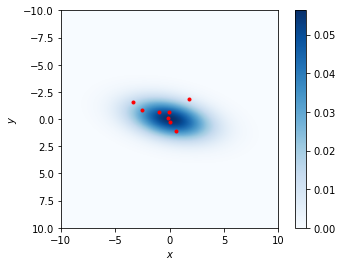

In [71]:
#Plot only the independent samples:
plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(independentsamples[:,0],independentsamples[:,1],'.',color='red')
plt.show()

#### We have increased the acceptance ratio, but we have decreased the relative number of independent samples.

A high acceptance ratio isn't always desirable. Can you think of any other reason why a high acceptance ratio might not be ideal?

### Let's try a multimodal distribution.

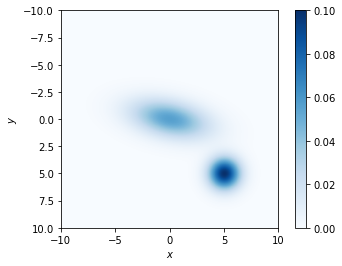

In [72]:
#Define a multimodal distribution (remember that the normalization doesn't matter):
def multimodal(samp,cov,invcov):
    x = samp[0]
    y = samp[1]
    return twoDGauss(samp,cov,invcov) + 0.1*np.exp(-0.5*((x-5.)**2 + (y-5)**2))

#Plot it:
mm = multimodal([gridx,gridy],cov,invcov)
plt.imshow(mm,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.show()

acceptance ratio: 0.605


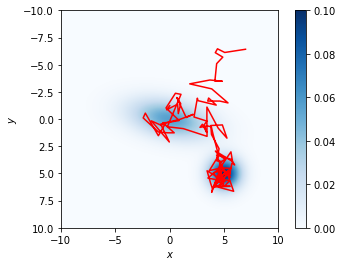

In [106]:
#Run a chain:
np.random.seed(15) # first try this
#np.random.seed(11) # then try this.
Nsteps = 200
sigmaprop = 1.0
D = 2
samples, ar = run_chain(Nsteps,np.transpose(np.array([[-10]*D,[10]*D])),sigmaprop,D,multimodal,cov,invcov)
print 'acceptance ratio:', ar

#Plot the chain on top of the 2D-density:
plt.imshow(mm,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(samples[:,0],samples[:,1],'-',color='red')
plt.show()

Use the different seeds provided above. What do you notice? Does this change if you draw more random samples? Remember: an MCMC is guaranteeed to converge to the true distribution, but it is not guaranteed to do so fast.

Marginalizing over parameters is trivial; just ignore them.

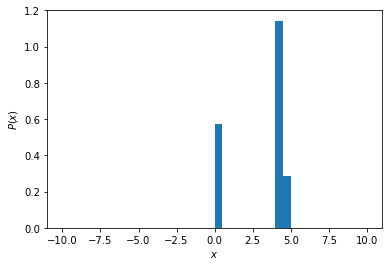

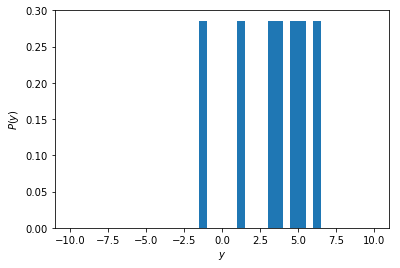

In [107]:
independent_samples = samples[50::25] #remove burn-in phase and correlated samples

x_values = independent_samples[:,0]

plt.hist(x_values,range=(-10,10),bins=40,normed=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(x)$')
plt.show()

y_values = independent_samples[:,1]

plt.hist(y_values,range=(-10,10),bins=40,normed=True)
plt.xlabel(r'$y$')
plt.ylabel(r'$P(y)$')
plt.show()

Now let's try again going to higher dimensions.

In [108]:
#Standard deviation in each direction for the D-dimensional Gaussian:
sigma = 2.

acceptance ratio: 0.447
dimension of the samples: (10,)


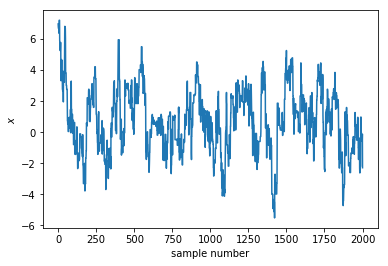

In [109]:
#Run a chain:
np.random.seed(15)
D = 10
Nsteps = 2000
sigmaprop = 1.0
samples, ar = run_chain(Nsteps,np.transpose(np.array([[-10]*D,[10]*D])),sigmaprop,D,DdimGauss,sigma,D)
print 'acceptance ratio:', ar

print 'dimension of the samples:', samples[0].shape

#Plot the first dimension of the samples:
plt.plot(samples[:,0])
plt.xlabel(r'sample number')
plt.ylabel(r'$x$')
plt.show()

What do you think a markov chain should look like? 

Increase the number of points.

## Back to data analysis

Suppose we measure a sin wave with an amplitude and a frequency, so that we have data

$d = x\ cos(y t) + n$,

where $n$ is some observational error. We will assume that we have several measurements and that the errors are Gaussian and independent.

2.5132741228718345


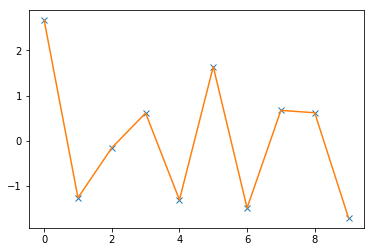

In [117]:
#Simulate a set of Nobs observations:
Nobs = 10
sigma = 0.5 #the standard deviation of the Gaussian noise
x = 2. #fix the true values of the two parameters
y = 4.*2.*np.pi/Nobs
print y
#Draw noise realizations:
np.random.seed(10)
n = np.random.normal(0.,sigma,Nobs)

#Observation times
t = np.arange(Nobs)

#Generate a data set:
d = x*np.cos(y*t) + n

plt.plot(d,'x')
plt.plot(d)
plt.show()

In [118]:
#Define the likelihood (which is proportional to the posterior, since we are assuming flat priors):
def likelihood(samp,d,t):
    x = samp[0]
    y = samp[1]
    
    res = (d-x*np.cos(y*t))**2 
    
    return np.exp(-0.5*(res.sum()/sigma**2))

In [137]:
np.random.seed(10)
#np.random.seed(None)
Nsteps = 20000
sigmaprop = 0.2
D=2
samples, ar = run_chain(Nsteps,np.array([[0,5],[0,np.pi]]),sigmaprop,D,likelihood,d,t)

acceptance ratio: 0.12485


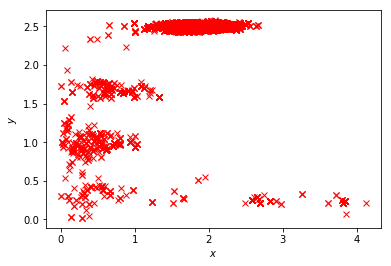

In [138]:
print 'acceptance ratio:', ar
plt.plot(samples[:,0],samples[:,1],'x',color='red')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


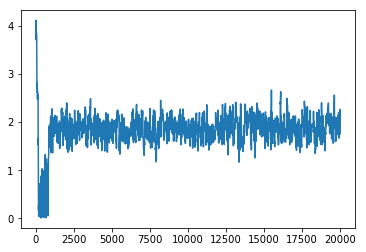

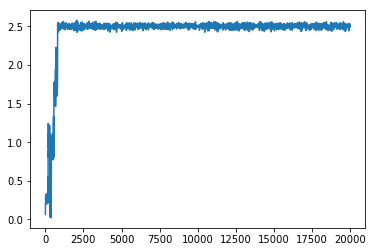

In [139]:
plt.plot(samples[:,0])
plt.show()

plt.plot(samples[:,1])
plt.show()

Unset the random seed above and run more chains. What do you notice? Do they converge to the same area? How fast? 

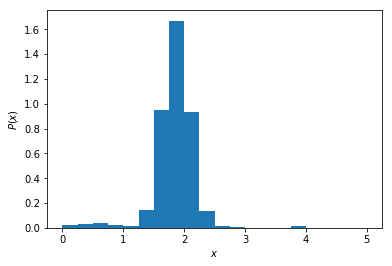

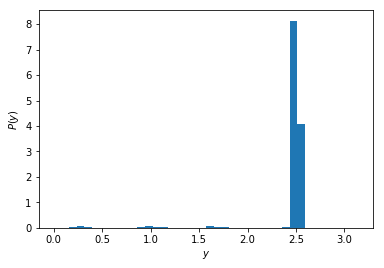

In [141]:
x_values = samples[:,0]

plt.hist(x_values,range=(0,5),bins=20,normed=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(x)$')
plt.show()

y_values = samples[:,1]

plt.hist(y_values,range=(0,np.pi),bins=40,normed=True)
plt.xlabel(r'$y$')
plt.ylabel(r'$P(y)$')
plt.show()

In practice: Run several chains with different starting values and make sure that they all converge to the same area.

## For further reading

* Gibbs sampling: Instead of drawing samples from $P(x,y)$, draw alternately from $P(x|y)$ and $P(y|x)$.
* Hamiltonian sampling: Think of the parameters as positions. Add a second set of unknown parameters, corresponding to momenta. Then follow the Hamiltonian equations of motion for some time to propose a new sample.
* Various python modules exist that have some of these methods pre-implemented, e.g.:

    - emcee (http://dan.iel.fm/emcee/current/)
    - pymc (https://pymc-devs.github.io/pymc/)
    